# Sentiment Analysis con KNN
## Clasificador en C++ 💪💪
Vamos a probar a nuestro bichito


Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.3.0
-- The CXX compiler identification is GNU 7.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/martin/.pyenv/shims/python (found version "3.6.5") 
-- Found PythonLibs: /home/martin/.pyenv/versions/3.6.5/lib/libpython3.6m.a
-- pybind11 v2.3.dev0
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/martin/Desktop/repos/metnum-tp2-20191c
-- Configuring 

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import sentiment


/home/martin/Desktop/repos/metnum-tp2-20191c/notebooks
Python 3.6.5


In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd

!cd ../data && tar -xvf *.tgz

df = pd.read_csv("../data/imdb_small.csv", index_col=0)

print("Cantidad de documentos: {}".format(df.shape[0]))

./._imdb_small.csv
imdb_small.csv
Cantidad de documentos: 12500


In [4]:
df.describe()

,type,review,label,file
count,12500,12500,12500,12500
unique,2,12469,2,12085
top,test,If this is not heavily featured on every list ...,neg,5876_1.txt
freq,6275,2,6322,2


In [5]:
text_train = df[df.type == 'train']["review"]
label_train = df[df.type == 'train']["label"]

text_test = df[df.type == 'test']["review"]
label_test = df[df.type == 'test']["label"]

print("Cantidad de instancias de entrenamiento = {}".format(len(text_train)))
print("Cantidad de instancias de test = {}".format(len(text_test)))


Cantidad de instancias de entrenamiento = 6225
Cantidad de instancias de test = 6275


In [6]:
print("Class balance : {} pos {} neg".format(
    (label_train == 'pos').sum() / label_train.shape[0], 
    (label_train == 'neg').sum() / label_train.shape[0]
))

Class balance : 0.49493975903614457 pos 0.5050602409638554 neg


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.90, min_df=0.01, max_features=5000)

vectorizer.fit(text_train)

X_train, y_train = vectorizer.transform(text_train), (label_train == 'pos').values
X_test, y_test = vectorizer.transform(text_test), (label_test == 'pos').values

In [27]:
%%time
clf.fit(pca_X_train, y_train)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_pred = clf.predict(pca_X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(acc))



Accuracy: 0.5655776892430279
CPU times: user 4.02 s, sys: 7.99 ms, total: 4.03 s
Wall time: 4.01 s


In [110]:
#All in one. Thuis cell defines the tester functions.
import time
import math
from sklearn.feature_extraction.text import CountVectorizer
def test(max_alpha_, min_alpha_, alpha_step_, max_df_=0.90, min_df_=0.01, max_features_=5000, knn_neighbours_=100, log=False):
    vectorizer = CountVectorizer(max_df=max_df_, min_df=min_df_, max_features=max_features_)
    vectorizer.fit(text_train)

    X_train, y_train = vectorizer.transform(text_train), (label_train == 'pos').values
    X_test, y_test = vectorizer.transform(text_test), (label_test == 'pos').values

    import sentiment

    clf = sentiment.KNNClassifier(knn_neighbours_)
    pca = sentiment.PCA(max_alpha_)
    #fitteo con el x_train calculado arriba
    pca.fit(X_train,10000, 0.0000000001)
    #loopeo para todos los alphas
    for alpha_ in range(min_alpha_, max_alpha_, alpha_step_):
        pca_X_train = pca.transform(X_train, alpha_)
        pca_X_test = pca.transform(X_test,alpha_)

        #Timing starts, same as previous cell:
        start = time.time()

        clf.fit(pca_X_train, y_train)
        from sklearn.metrics import accuracy_score
        from sklearn.metrics import precision_score
        from sklearn.metrics import recall_score

        y_pred = clf.predict(pca_X_test)

        acc = accuracy_score(y_test, y_pred)
        pre = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = 2*(pre*rec)/(pre+rec)
        #Timing ends, again, like in previous cell.
        end = time.time()
        delta_time = end - start
        delta_time_str = str(round(delta_time, 2))
        if log:
            comma = ", "
            f = open("../data/test_results/out.csv","a+")
            f.write("\n")
            f.write(str(round(acc,2)) + comma)
            f.write(str(round(pre,2)) + comma)
            f.write(str(round(rec,2)) + comma)
            f.write(delta_time_str + comma)
            f.write(str(round(max_df_,2)) + comma)
            f.write(str(round(min_df_,2)) + comma)
            f.write(str(round(max_features_,2)) + comma)
            f.write(str(round(knn_neighbours_,2)) + comma)
            f.write(str(round(alpha_,2))+ comma)
            f.write(str(round(f1,2)))
            f.close()

    return f1


In [11]:
#Actual testing, this cell runs the tester functions and logs or prints results.
#It may take a long time to run.
import numpy as np
#OJO, puse esto en true para testear
test_individually = False
if test_individually:
    test(max_alpha_=11, min_alpha_= 10, alpha_step_=2,max_df_=0.90, min_df_=0.01, max_features_=5000, knn_neighbours_=10,log=True)
else:
    test(max_alpha_= 10, min_alpha_= 2, alpha_step_=2, knn_neighbours_ = 10,log=True)

In [108]:
import random as rnd
def get_random_vector():
    res = []
    res.append(rnd.uniform(0.0, 0.9999))#max_df_
    res.append(rnd.uniform(0.0, res[0]))#min_df_
    res.append(rnd.uniform(0.0, 5000))#max_features_
    res.append(rnd.uniform(0.0, 400))#knn_neighbours_
    res.append(rnd.uniform(0.0, 200))#alpha_
    return res
               
def test_gd(max_df_, min_df_, max_features_, knn_neighbours_, alpha_, log):
    return test(alpha_+1, alpha_, 1, max_df_, min_df_, max_features_, knn_neighbours_, log)

#def test(max_alpha_, min_alpha_, alpha_step_, max_df_=0.90, min_df_=0.01, max_features_=5000, knn_neighbours_=100, log=False):

def gradient_descent(p0, start_value, max_iters, debug = False):
    reset_value = 0.0
    old_val = start_value
    p1 = [p0[0], p0[1], p0[2], p0[3], p0[4]]
    resolution = 1.0
    resolution_max = 0.05 #(Less than 0.02 seems useless)
    log = True

    while True:
        
        p0 = p1
        print("Current vector: " + str(p0))
        step0 = resolution*0.05#max_df
        step1 = resolution*0.05 #min_df
        step2 = max(1,int(resolution*200))#max_features
        step3 = max(1,int(resolution*20))#knn_neighbours
        step4 = max(1,int(resolution*40))#alpha

        changed = False
        
        if max_iters == 0:
            print("Ending descent due to max_iters")
            break
        max_iters -= 1
        
        #max_df_rise
        if p0[0]+step0 < 1.0:
            next_val = test_gd(p0[0]+step0, p0[1], p0[2], p0[3], p0[4], log)
            if next_val > old_val:
                p1 = [p0[0]+step0, p0[1], p0[2], p0[3], p0[4]]
                old_val = next_val
                changed = True

        #max_df_decrement
        if p0[0]-step0 > p0[1]: #should be bigger than min_df
            next_val = test_gd(p0[0]-step0, p0[1], p0[2], p0[3], p0[4], log)
            if next_val > old_val:
                p1 = [p0[0]-step0, p0[1], p0[2], p0[3], p0[4]]
                old_val = next_val
                changed = True

        #min_df_rise
        if p0[1]+step1 < p0[0]: #should be smaller than max_df
            next_val = test_gd(p0[0], p0[1]+step1, p0[2], p0[3], p0[4], log)
            if next_val > old_val:
                p1 = [p0[0], p0[1]+step1, p0[2], p0[3], p0[4]]
                old_val = next_val
                changed = True
            
        #min_df_decrement
        if p0[1]-step1 > 0:
            next_val = test_gd(p0[0], p0[1]-step1, p0[2], p0[3], p0[4], log)
            if next_val > old_val:
                p1 = [p0[0], p0[1]-step1, p0[2], p0[3], p0[4]]
                old_val = next_val
                changed = True
        
        #max_features_rise
        next_val = test_gd(p0[0], p0[1], int(p0[2]+step2), p0[3], p0[4], log)
        if next_val > old_val:
            p1 = [p0[0], p0[1], p0[2]+step2, p0[3], p0[4]]
            old_val = next_val
            changed = True
            
        #max_features_decrement
        if p0[2]-step2 >= 1:
            next_val = test_gd(p0[0], p0[1], int(p0[2]-step2), p0[3], p0[4], log)
            if next_val > old_val:
                p1 = [p0[0], p0[1], p0[2]-step2, p0[3], p0[4]]
                old_val = next_val
                changed = True

        #knn_neighbours_rise #TODO: Compare with max neighbours.
        next_val = test_gd(p0[0], p0[1], p0[2], int(p0[3]+step3), p0[4], log)
        if next_val > old_val:
            p1 = [p0[0], p0[1], p0[2], p0[3]+step3, p0[4]]
            old_val = next_val
            changed = True
            
        #knn_neighbours_decrement
        if p0[3]-step3 >= 1:
            next_val = test_gd(p0[0], p0[1], p0[2], int(p0[3]-step3), p0[4], log)
            if next_val > old_val:
                p1 = [p0[0], p0[1], p0[2], p0[3]-step3, p0[4]]
                old_val = next_val
                changed = True

        #alpha_rise
        next_val = test_gd(p0[0], p0[1], p0[2], p0[3], int(p0[4]+step4), log)
        if next_val > old_val:
            p1 = [p0[0], p0[1], p0[2], p0[3], p0[4]+step4]
            old_val = next_val
            changed = True

        #alpha_decrement
        if p0[0]+step0 >= 1:
            next_val = test_gd(p0[0], p0[1], p0[2], p0[3], int(p0[4]-step4), log)
            if next_val > old_val:
                p1 = [p0[0], p0[1], p0[2], p0[3], p0[4]-step4]
                old_val = next_val
                changed = True

        if not changed:
            resolution *= 0.9
            if debug:
                print("Best value in step positions:  (" + str(old_val) + "), rising resolution to: "+ str(resolution))
                print("Argument vector: " + str(p1))
            if resolution < resolution_max:
                resolution = 1.0
                print("Resolution got to high, switching to random vector.")
                print("Local maxima value found: "+ str(old_val))
                print("Local maxima vector is: " + str(p1))
                
                f = open("../data/test_results/max_out.csv","a+")
                f.write("\nLocal maxima value found: "+ str(old_val))
                f.write(". Local maxima vector is: " + str(p1))
                f.close()
                
                old_val = reset_value
                p1 = get_random_vector()
            
        if debug and changed:
            print("Found a better value: " + str(old_val))
            print("New argument vector: " + str(p1) + "\n")
            
p0 = [0.49, 0.01, 5000, 50, 100] #Good one for pca
v0 = test_gd(p0[0], p0[1], p0[2], p0[3], p0[4], log=True)
gradient_descent(p0, v0, max_iters = 4000, debug=True)



Current vector: [0.49, 0.01, 5000, 50, 100]
Found a better value: 7200
New argument vector: [0.49, 0.01, 4800, 50, 100]

Current vector: [0.49, 0.01, 4800, 50, 100]
Found a better value: 7400
New argument vector: [0.49, 0.01, 4600, 50, 100]

Current vector: [0.49, 0.01, 4600, 50, 100]
Found a better value: 7600
New argument vector: [0.49, 0.01, 4400, 50, 100]

Current vector: [0.49, 0.01, 4400, 50, 100]
Found a better value: 7800
New argument vector: [0.49, 0.01, 4200, 50, 100]

Current vector: [0.49, 0.01, 4200, 50, 100]
Found a better value: 8000
New argument vector: [0.49, 0.01, 4000, 50, 100]

Current vector: [0.49, 0.01, 4000, 50, 100]
Found a better value: 8200
New argument vector: [0.49, 0.01, 3800, 50, 100]

Current vector: [0.49, 0.01, 3800, 50, 100]
Found a better value: 8400
New argument vector: [0.49, 0.01, 3600, 50, 100]

Current vector: [0.49, 0.01, 3600, 50, 100]
Found a better value: 8600
New argument vector: [0.49, 0.01, 3400, 50, 100]

Current vector: [0.49, 0.01, 340

Found a better value: 9998
New argument vector: [0.6734680602940958, 0.4863069320330675, 2002.5312223038463, 375.8952273179999, 24.886428260881942]

Current vector: [0.6734680602940958, 0.4863069320330675, 2002.5312223038463, 375.8952273179999, 24.886428260881942]
Best value in step positions:  (9998), rising resolution to: 0.9
Argument vector: [0.6734680602940958, 0.4863069320330675, 2002.5312223038463, 375.8952273179999, 24.886428260881942]
Current vector: [0.6734680602940958, 0.4863069320330675, 2002.5312223038463, 375.8952273179999, 24.886428260881942]
Best value in step positions:  (9998), rising resolution to: 0.81
Argument vector: [0.6734680602940958, 0.4863069320330675, 2002.5312223038463, 375.8952273179999, 24.886428260881942]
Current vector: [0.6734680602940958, 0.4863069320330675, 2002.5312223038463, 375.8952273179999, 24.886428260881942]
Best value in step positions:  (9998), rising resolution to: 0.7290000000000001
Argument vector: [0.6734680602940958, 0.4863069320330675, 

Current vector: [0.4319100514564547, 0.05270675057381365, 1991.083649085822, 311.70890689866144, 87.33425161739308]
Best value in step positions:  (9991.083649085822), rising resolution to: 0.1500946352969992
Argument vector: [0.4319100514564547, 0.05270675057381365, 1991.083649085822, 311.70890689866144, 87.33425161739308]
Current vector: [0.4319100514564547, 0.05270675057381365, 1991.083649085822, 311.70890689866144, 87.33425161739308]
Best value in step positions:  (9991.083649085822), rising resolution to: 0.13508517176729928
Argument vector: [0.4319100514564547, 0.05270675057381365, 1991.083649085822, 311.70890689866144, 87.33425161739308]
Current vector: [0.4319100514564547, 0.05270675057381365, 1991.083649085822, 311.70890689866144, 87.33425161739308]
Best value in step positions:  (9991.083649085822), rising resolution to: 0.12157665459056936
Argument vector: [0.4319100514564547, 0.05270675057381365, 1991.083649085822, 311.70890689866144, 87.33425161739308]
Current vector: [0.4

Current vector: [0.7390690327908077, 0.11105605245001715, 3145.8363079658484, 351.99489245494186, 103.37976697415752]
Found a better value: 9055
New argument vector: [0.7390690327908077, 0.11105605245001715, 2945.8363079658484, 351.99489245494186, 103.37976697415752]

Current vector: [0.7390690327908077, 0.11105605245001715, 2945.8363079658484, 351.99489245494186, 103.37976697415752]
Found a better value: 9255
New argument vector: [0.7390690327908077, 0.11105605245001715, 2745.8363079658484, 351.99489245494186, 103.37976697415752]

Current vector: [0.7390690327908077, 0.11105605245001715, 2745.8363079658484, 351.99489245494186, 103.37976697415752]
Found a better value: 9455
New argument vector: [0.7390690327908077, 0.11105605245001715, 2545.8363079658484, 351.99489245494186, 103.37976697415752]

Current vector: [0.7390690327908077, 0.11105605245001715, 2545.8363079658484, 351.99489245494186, 103.37976697415752]
Found a better value: 9655
New argument vector: [0.7390690327908077, 0.1110

Found a better value: 9930
New argument vector: [0.8755361901238444, 0.4539497444106849, 1930.468369372331, 54.48284621603023, 43.803167880271054]

Current vector: [0.8755361901238444, 0.4539497444106849, 1930.468369372331, 54.48284621603023, 43.803167880271054]
Found a better value: 9930.468369372331
New argument vector: [0.9119861901238444, 0.4539497444106849, 1930.468369372331, 54.48284621603023, 43.803167880271054]

Current vector: [0.9119861901238444, 0.4539497444106849, 1930.468369372331, 54.48284621603023, 43.803167880271054]
Best value in step positions:  (9930.468369372331), rising resolution to: 0.6561000000000001
Argument vector: [0.9119861901238444, 0.4539497444106849, 1930.468369372331, 54.48284621603023, 43.803167880271054]
Current vector: [0.9119861901238444, 0.4539497444106849, 1930.468369372331, 54.48284621603023, 43.803167880271054]
Found a better value: 9939
New argument vector: [0.9119861901238444, 0.4539497444106849, 2061.468369372331, 54.48284621603023, 43.8031678

Best value in step positions:  (9982), rising resolution to: 0.43046721000000016
Argument vector: [0.4119061171459347, 0.31962195146474615, 2018.5004314346575, 172.27120669843697, 29.717146802804773]
Current vector: [0.4119061171459347, 0.31962195146474615, 2018.5004314346575, 172.27120669843697, 29.717146802804773]
Best value in step positions:  (9982), rising resolution to: 0.38742048900000015
Argument vector: [0.4119061171459347, 0.31962195146474615, 2018.5004314346575, 172.27120669843697, 29.717146802804773]
Current vector: [0.4119061171459347, 0.31962195146474615, 2018.5004314346575, 172.27120669843697, 29.717146802804773]
Best value in step positions:  (9982), rising resolution to: 0.34867844010000015
Argument vector: [0.4119061171459347, 0.31962195146474615, 2018.5004314346575, 172.27120669843697, 29.717146802804773]
Current vector: [0.4119061171459347, 0.31962195146474615, 2018.5004314346575, 172.27120669843697, 29.717146802804773]
Best value in step positions:  (9982), rising 

Current vector: [0.6057608388240546, 0.26887245062484616, 1979.4108347697338, 188.89510239106073, 129.9986202999189]
Found a better value: 9980
New argument vector: [0.6057608388240546, 0.26887245062484616, 2020.4108347697338, 188.89510239106073, 129.9986202999189]

Current vector: [0.6057608388240546, 0.26887245062484616, 2020.4108347697338, 188.89510239106073, 129.9986202999189]
Best value in step positions:  (9980), rising resolution to: 0.1853020188851842
Argument vector: [0.6057608388240546, 0.26887245062484616, 2020.4108347697338, 188.89510239106073, 129.9986202999189]
Current vector: [0.6057608388240546, 0.26887245062484616, 2020.4108347697338, 188.89510239106073, 129.9986202999189]
Found a better value: 9983
New argument vector: [0.6057608388240546, 0.26887245062484616, 1983.4108347697338, 188.89510239106073, 129.9986202999189]

Current vector: [0.6057608388240546, 0.26887245062484616, 1983.4108347697338, 188.89510239106073, 129.9986202999189]
Found a better value: 9983.4108347

Best value in step positions:  (9957.754081232055), rising resolution to: 0.38742048900000015
Argument vector: [0.9918437156584545, 0.00029681191746442915, 1957.7540812320558, 302.7205216831077, 89.32303360676492]
Current vector: [0.9918437156584545, 0.00029681191746442915, 1957.7540812320558, 302.7205216831077, 89.32303360676492]
Found a better value: 9966
New argument vector: [0.9918437156584545, 0.00029681191746442915, 2034.7540812320558, 302.7205216831077, 89.32303360676492]

Current vector: [0.9918437156584545, 0.00029681191746442915, 2034.7540812320558, 302.7205216831077, 89.32303360676492]
Best value in step positions:  (9966), rising resolution to: 0.34867844010000015
Argument vector: [0.9918437156584545, 0.00029681191746442915, 2034.7540812320558, 302.7205216831077, 89.32303360676492]
Current vector: [0.9918437156584545, 0.00029681191746442915, 2034.7540812320558, 302.7205216831077, 89.32303360676492]
Best value in step positions:  (9966), rising resolution to: 0.3138105960900

Argument vector: [0.4490371196715496, 0.11081300605323736, 1958.982959519908, 188.47494809756537, 42.94445991872286]
Current vector: [0.4490371196715496, 0.11081300605323736, 1958.982959519908, 188.47494809756537, 42.94445991872286]
Best value in step positions:  (9958.982959519908), rising resolution to: 0.38742048900000015
Argument vector: [0.4490371196715496, 0.11081300605323736, 1958.982959519908, 188.47494809756537, 42.94445991872286]
Current vector: [0.4490371196715496, 0.11081300605323736, 1958.982959519908, 188.47494809756537, 42.94445991872286]
Found a better value: 9965
New argument vector: [0.4490371196715496, 0.11081300605323736, 2035.982959519908, 188.47494809756537, 42.94445991872286]

Current vector: [0.4490371196715496, 0.11081300605323736, 2035.982959519908, 188.47494809756537, 42.94445991872286]
Best value in step positions:  (9965), rising resolution to: 0.34867844010000015
Argument vector: [0.4490371196715496, 0.11081300605323736, 2035.982959519908, 188.474948097565

Best value in step positions:  (9953), rising resolution to: 0.47829690000000014
Argument vector: [0.6306161138027001, 0.317298246468716, 2047.9732790924963, 69.48450777328628, 63.918225764701276]
Current vector: [0.6306161138027001, 0.317298246468716, 2047.9732790924963, 69.48450777328628, 63.918225764701276]
Best value in step positions:  (9953), rising resolution to: 0.43046721000000016
Argument vector: [0.6306161138027001, 0.317298246468716, 2047.9732790924963, 69.48450777328628, 63.918225764701276]
Current vector: [0.6306161138027001, 0.317298246468716, 2047.9732790924963, 69.48450777328628, 63.918225764701276]
Found a better value: 9961
New argument vector: [0.6306161138027001, 0.317298246468716, 1961.9732790924963, 69.48450777328628, 63.918225764701276]

Current vector: [0.6306161138027001, 0.317298246468716, 1961.9732790924963, 69.48450777328628, 63.918225764701276]
Found a better value: 9961.973279092497
New argument vector: [0.6521394743027001, 0.317298246468716, 1961.9732790

In [47]:
#GRAFICADOR
def common_graph(csv, x, y):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    df = pd.read_csv(csv)
    plot = sns.lineplot(x=x, y=y, data=df);
    plot.legend([x, y]);
    
def heatmap_graph(csv, x, y, z):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    
     
    df = pd.read_csv(csv)
    df = df.pivot(index=x, columns=y, values=z)
    plot = sns.heatmap(df)
    plot.legend([x, y]);



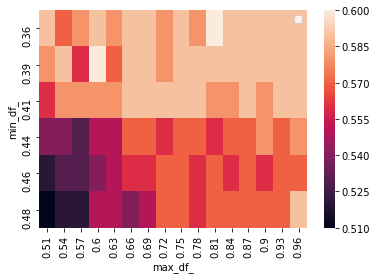

In [48]:
#common_graph('../data/test_results/out_test_features_s.csv', "acc", " max_features_")
heatmap_graph('../data/test_results/out_test_min_max_s.csv', "min_df_", "max_df_", "acc")

In [19]:
#Checkeo de PCA.fit en python. Deberia dar muy similar a C++, salvo por errores de rendodeo.
#Revisar los au
import numpy as np

X = np.array([[2,429,608,192],[173,746,800,125],[14,225,6,9]]) 
print(X.shape)
#X = np.array([[1,2,3,4],[105,107,113,125],[14,225,6,9],[17,23,15,94],[1784,12,19,135]]) 
mu = X.sum(axis = 0)
mu = mu/X.shape[0]
#M = (X - X.mean(axis=0))
M = (X - mu) / np.sqrt(X.shape[0]-1)
cov_matrix = M.T @ M  
print(cov_matrix)
w, V = np.linalg.eig(cov_matrix)

# A veces aparecen números complejos acá. Los descartamos
w = np.real(w)
V = np.real(V)
print(V)
print(w)

(3, 4)
[[  9111.          22433.          25309.            798.5       ]
 [ 22433.          68924.33333333  99557.66666667  12754.83333333]
 [ 25309.          99557.66666667 171617.33333333  31567.66666667]
 [   798.5         12754.83333333  31567.66666667   8572.33333333]]
[[ 0.14059445  0.51524127  0.83783397  0.27741273]
 [ 0.51014667  0.60482284 -0.39447156 -0.53635408]
 [ 0.83662887 -0.37451917  0.03618136  0.3973405 ]
 [ 0.14154756 -0.47796565  0.37565588 -0.69100434]]
[ 2.41918091e+05  1.63069093e+04 -5.40693656e-12  8.22213615e-12]
